# カタカナの画像認識モデル
手書きカタカナ「アイウエオカキクケコサシスセソ」の15文字を高い精度で識別できるモデルを構築する

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

## MLFlow準備

In [165]:
import os
import configparser
import mlflow
import mlflow.sklearn
# ローカルDB方式の場合に必要。今回はローカルGUI方式のため不要
# import sqlite3

In [166]:
# MLFlowの設定ファイル読み込み
cfg = configparser.ConfigParser()
cfg.read('./config.ini', encoding='utf-8')
# 各種パスを指定
# DB_PATH = cfg['Path']['db_path']

['./config.ini']

In [167]:
# %% エクスペリメントの作成
# Artifactストレージの場所を指定
ARTIFACT_LOCATION = cfg['Path']['artifact_location']
# Experimentの生成
EXPERIMENT_NAME = 'cnn_tuning'
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:  # 当該Experiment存在しないとき、新たに作成
    experiment_id = mlflow.create_experiment(
                            name=EXPERIMENT_NAME,
                            artifact_location=ARTIFACT_LOCATION)
else: # 当該Experiment存在するとき、IDを取得
    experiment_id = experiment.experiment_id

## データを読む1

In [168]:
train_data = np.load("../1_data/train_data.npy")
train_label = np.load("../1_data/train_label.npy")
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


In [169]:
# 正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')
# print(train_data)

In [170]:
# 配列形式変更
train_data = train_data.reshape(-1, 28*28)
print("train_data.shape=", train_data.shape)

train_data.shape= (3000, 784)


## trainとtestに分割する
- 読み込んだtrainデータから、学習後の検証用のtestデータを除いておく。
- random_stateやtest_sizeは変更しない。

In [171]:
X_train_all, X_test, y_train_all, y_test = train_test_split(train_data, train_label, 
                                                    test_size=0.3, random_state=1234,
                                                    shuffle=True
                                                   )

print(X_train_all.shape, X_test.shape)

(2100, 784) (900, 784)


In [172]:
# データを間引く場合はここで調整する
X_train = X_train_all
y_train = y_train_all

- 訓練用データは2100個、検証用データは900個
- 1枚1枚の画像は724(=28*28)の格子データ

## データ拡張
** ここでAugmentorかImageDataGeneratorを実装する**
テキストp131-133にどういったデータ拡張が向いているかの記載あり
- 拡大・縮小、プーリングで吸収しきれない大幅な回転、変形（シアー、Perspective skew、Elastic distortion）、Random erasing
- 拡張された画像の中に運用時に入力される画像にできるだけ近いものが含まれていることが重要
 - Augumentor（Perspective skew、Elastic Eistortion、Random erasing）
 - ImageDataGenerator（回転、シアー、拡大・縮小）

In [173]:
# X_train[0].shape

(784,)

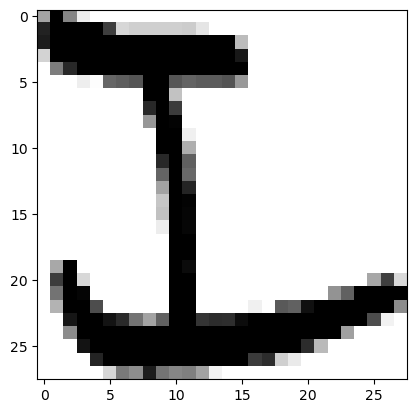

(1, 28, 28)


In [174]:
# from matplotlib import cm
# from PIL import Image
# train_data = X_train.reshape(-1, 1, 28, 28)
# train_label = y_train
# # print(f'train_labelの形状：{train_label.shape}')
# # print(f'train_label自体：{train_label}')
# # label = onehot_to_str(train_label)
# # print(len(label))
# # print(type(label))
# # print(f'label自体：{label}')
# ind = 6 #この数字を変更するとカタカナが変化する

# # 画像
# img = train_data[ind,:,:,:,]
# plt.imshow(img[0,:,:], cmap='gray')
# plt.show()
# print(img.shape)
# # print(img)

In [175]:
# img.shape

(1, 28, 28)

In [176]:
# # https://dev.classmethod.jp/articles/keras-image-data-generator/
# from keras.preprocessing.image import ImageDataGenerator
# def plot_augmentation_image(train_sample, params):

#     # 同じ画像を16個複製する
#     train_samples = np.repeat(train_sample.reshape((1, *train_sample.shape)), 16, axis=0)

#     # 16個に対してparamsで与えられた変換を実施
#     data_generator = ImageDataGenerator(**params)
#     generator = data_generator.flow(train_samples, batch_size=16)

#     # 変換後のデータを取得
#     batch_x = generator.next()

#     # 変換後はfloat32となっているため、uint8に変換
#     batch_x = batch_x.astype(np.uint8)

#     # 描画処理
#     plt.figure(figsize=(10,10))
#     for i in range(16):
#         plt.subplot(4,4,i+1)
#         # print(batch_x[i,0].shape)
#         plt.imshow(batch_x[i,0], cmap='gray')
#         plt.tick_params(labelbottom='off')
#         plt.tick_params(labelleft='off')
# # plt.imshow(img[0,:,:], cmap='gray')


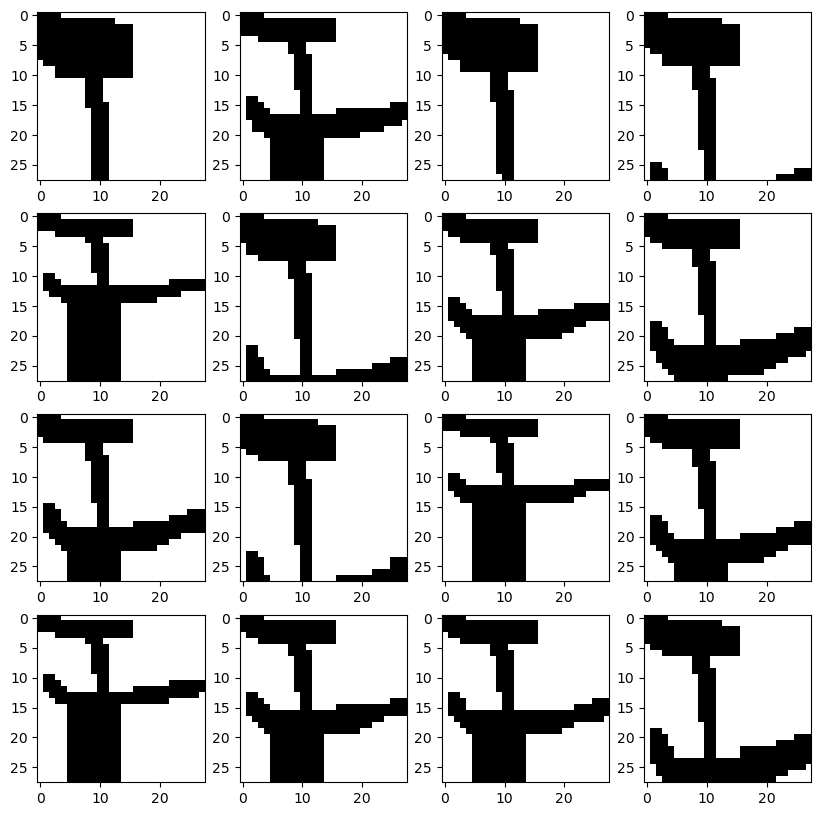

In [177]:
# params = {
#     'zoom_range': [0.5, 2.0]
# }
# plot_augmentation_image(img, params)


In [178]:
# params = {
#     'zoom_range': [0.5, 2.0],
#     'rotation_range': 45,
#     # 'vertical_flip': True,
#     # 'horizontal_flip': True,
#     # 'height_shift_range': 0.1,
#     # 'width_shift_range': 0.1,
#     'shear_range': 90,
#     # 'channel_shift_range': 127
# }
# generator = ImageDataGenerator(**params)

# # train_iter = generator.flow(x=train_images, y=train_labels)
# train_iter = generator.flow(x=X_train.reshape(-1, 1, 28, 28), y=y_train)


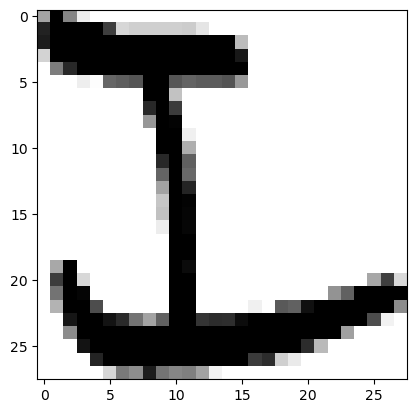

In [179]:
# train_data = X_train.reshape(-1, 1, 28, 28)
# train_label = y_train
# ind = 6 #この数字を変更するとカタカナが変化する

# # 画像
# img = train_data[ind,:,:,:,]
# plt.imshow(img[0,:,:], cmap='gray')
# plt.show()


下記のlabelはkeyだけをreturnするのでseとかになる。label化するのは後工程でOK

In [180]:
# # train(訓練データ)とtest(検証用データ)の形状を確認する
# print(f'trainの形状：{X_train.shape}')
# print(f'train_labelの形状：{y_train.shape}')
# print(f'testの形状：{X_test.shape}')
# print(f'test_labelの形状：{y_test.shape}')

trainの形状：(2100, 784)
train_labelの形状：(2100, 15)
testの形状：(900, 784)
test_labelの形状：(900, 15)


## 学習

### 配列形状の変形
CNNの場合は(データ数、チャネル数、横方向、縦方向)とする

In [190]:
train = X_train.reshape(-1, 1, 28, 28)
test = X_test.reshape(-1, 1, 28, 28)

In [191]:
print(f'trainの形状：{train.shape}')
print(f'testの形状：{test.shape}')

trainの形状：(2100, 1, 28, 28)
testの形状：(900, 1, 28, 28)


In [192]:
# https://dev.classmethod.jp/articles/keras-image-data-generator/
from keras.preprocessing.image import ImageDataGenerator
def plot_augmentation_image(train_sample, params):

    # 同じ画像を16個複製する
    train_samples = np.repeat(train_sample.reshape((1, *train_sample.shape)), 16, axis=0)

    # 16個に対してparamsで与えられた変換を実施
    data_generator = ImageDataGenerator(**params)
    generator = data_generator.flow(train_samples, batch_size=16)

    # 変換後のデータを取得
    batch_x = generator.next()

    # 変換後はfloat32となっているため、uint8に変換
    batch_x = batch_x.astype(np.uint8)

    # 描画処理
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4,i+1)
        # print(batch_x[i,0].shape)
        plt.imshow(batch_x[i,0], cmap='gray')
        plt.tick_params(labelbottom='off')
        plt.tick_params(labelleft='off')
# plt.imshow(img[0,:,:], cmap='gray')


In [193]:
# 水増し用のデータ作成
train_tmp = train[:,:,:,:]
y_tmp = y_train[:,:]
# データ数を削減
# train_tmp = train[0:2,:,:,:]
# y_tmp = y_train[0:2,:]
print(train_tmp.shape)
print(y_tmp.shape)

(2100, 1, 28, 28)
(2100, 15)


In [194]:
# train_tmp.shape[3]

In [195]:
params = {
    'zoom_range': [0.5, 2.0],
    'rotation_range': 45,
    # 'vertical_flip': True,
    # 'horizontal_flip': True,
    # 'height_shift_range': 0.1,
    # 'width_shift_range': 0.1,
    'shear_range': 45,
    # 'channel_shift_range': 127
}
generator = ImageDataGenerator(**params)

# train_iter = generator.flow(x=train_images, y=train_labels)
# train_iter = generator.flow(x=train_tmp, y=y_tmp)
train_tmp_t = train_tmp.transpose(0,2,3,1)
print(train_tmp_t.shape)
# train_iter = generator.flow(x=train_tmp_t, y=y_tmp, batch_size=1, save_to_dir="../1_data/idgen/",
#                  save_format='png')#, save_prefix='out_%s_from_npy_'%label)
train_iter = generator.flow(x=train_tmp_t, y=y_tmp, batch_size=1)#画像を保存しない場合

num_image = 6300 #水増しデータ数
for i in range(num_image):
    batches = train_iter.next()
    # print(batches[0].shape)
    # print(batches[1]) #これがラベル
    # 生成されたデータbatches[0]を追加する
    train_tmp_t = np.vstack([train_tmp_t, batches[0]])
    y_tmp = np.vstack([y_tmp, batches[1]])

(2100, 28, 28, 1)


In [196]:
print(train_tmp_t.shape)
print(y_tmp.shape)

(8400, 28, 28, 1)
(8400, 15)


In [197]:
train_added = train_tmp_t.transpose(0,3,1,2)
y_train_added = y_tmp

In [198]:
train.shape

(2100, 1, 28, 28)

In [199]:
print(train_added.shape)
print(y_train_added.shape)

(8400, 1, 28, 28)
(8400, 15)


- ここまででimageDataGeneratorを使ったデータ拡張を実装できた。
- あとはimageDataGeneratorのパラメータをいろいろ試してみて、データを拡張して、学習してみる。

### ミニバッチ学習

In [200]:
# ### SimpleConvNetクラスの実装
# from collections import OrderedDict
# from common.layers import Convolution, MaxPooling, ReLU, Affine, SoftmaxWithLoss
# from common.gradient import numerical_gradient
# from common.optimizer import RMSProp, NesterovAG

# class SimpleConvNet:
#     def __init__(self, input_dim=(1, 28, 28), 
#                  conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
#                  pool_param={'pool_size':2, 'pad':0, 'stride':2},
#                  hidden_size=100, output_size=10, weight_init_std=0.01, batch_size=100):
#         """
#         input_size : tuple, 入力の配列形状(チャンネル数、画像の高さ、画像の幅)
#         conv_param : dict, 畳み込みの条件
#         pool_param : dict, プーリングの条件
#         hidden_size : int, 隠れ層のノード数
#         output_size : int, 出力層のノード数
#         weight_init_std ： float, 重みWを初期化する際に用いる標準偏差
#         """
                
#         filter_num = conv_param['filter_num']
#         filter_size = conv_param['filter_size']
#         filter_pad = conv_param['pad']
#         filter_stride = conv_param['stride']
        
#         pool_size = pool_param['pool_size']
#         pool_pad = pool_param['pad']
#         pool_stride = pool_param['stride']
        
#         input_size = input_dim[1]
#         conv_output_size = (input_size + 2*filter_pad - filter_size) // filter_stride + 1 # 畳み込み後のサイズ(H,W共通)
#         # 4_6_を参考にすると、pool_output_size=out_h、
#         pool_output_size = (conv_output_size + 2*pool_pad - pool_size) // pool_stride + 1 # プーリング後のサイズ(H,W共通)
#         # Day3 p29を参考にすると、filter_num=FN, pool_output_size=OH=OW
#         pool_output_pixel = filter_num * pool_output_size * pool_output_size # プーリング後のピクセル総数
#         print("class初期化時の値", filter_num, filter_size, filter_pad, input_size, batch_size, weight_init_std)
        
#         # 重みの初期化
#         self.params = {}
#         std = weight_init_std
#         # Day3のp29において、filter_num=FN, input_dim[0]=C, filter_size=FH=FW
#         self.params['W1'] = std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size) # W1は畳み込みフィルターの重みになる
#         self.params['b1'] = np.zeros(filter_num) #b1は畳み込みフィルターのバイアスになる
#         self.params['W2'] = std *  np.random.randn(pool_output_pixel, hidden_size)
#         self.params['b2'] = np.zeros(hidden_size)
#         self.params['W3'] = std *  np.random.randn(hidden_size, output_size)
#         self.params['b3'] = np.zeros(output_size)

#         # レイヤの生成
#         self.layers = OrderedDict()
#         # Day3 p20を参考に、畳み込み層→活性化関数→プーリング層→全結合層→活性化関数→全結合層→ソフトマックス関数
#         self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
#                                            conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
#         self.layers['ReLU1'] = ReLU()
#         self.layers['Pool1'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
#         self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
#         self.layers['ReLU2'] = ReLU()
#         self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

#         self.last_layer = SoftmaxWithLoss()

#     def predict(self, x):
#         for layer in self.layers.values():
#             x = layer.forward(x)

#         return x

#     def loss(self, x, t):
#         """
#         損失関数
#         x : 入力データ
#         t : 教師データ
#         """
#         y = self.predict(x)
#         return self.last_layer.forward(y, t)

#     def accuracy(self, x, t, batch_size=100):
#         # print("SimpleConvNet.accuracyのbatch_size", batch_size)
#         # batch_size = self.batch_size
#         if t.ndim != 1 : t = np.argmax(t, axis=1)
        
#         acc = 0.0
        
#         for i in range(int(x.shape[0] / batch_size)):
#             tx = x[i*batch_size:(i+1)*batch_size]
#             tt = t[i*batch_size:(i+1)*batch_size]
#             y = self.predict(tx)
#             y = np.argmax(y, axis=1)
#             acc += np.sum(y == tt) 
        
#         return acc / x.shape[0]

#     def gradient(self, x, t):
#         """勾配を求める（誤差逆伝播法）
#         Parameters
#         ----------
#         x : 入力データ
#         t : 教師データ
#         Returns
#         -------
#         各層の勾配を持ったディクショナリ変数
#             grads['W1']、grads['W2']、...は各層の重み
#             grads['b1']、grads['b2']、...は各層のバイアス
#         """
#         # forward
#         self.loss(x, t)

#         # backward
#         dout = 1
#         dout = self.last_layer.backward(dout)

#         layers = list(self.layers.values())
#         layers.reverse()
#         for layer in layers:
#             dout = layer.backward(dout)

#         # 設定
#         grads = {}
#         grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
#         grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
#         grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

#         return grads

In [201]:
# データを間引く
# x = train[:1000,:]; t = y_train[:1000,:] # x: 訓練データ、t: テストデータ
x = train_added; t = y_train_added
# x = train; t = y_train
x = x.reshape(-1,1,28,28) # 配列形式の変形

In [202]:
print(x.shape)

(8400, 1, 28, 28)


In [203]:
from common.layers import SimpleConvNet
from common.optimizer import RMSProp, NesterovAG
def model_train(epochs, batch_size, filter_num, filter_size, weight_init_std):
    optimizer = RMSProp(lr=0.01, rho=0.9)
    # optimizer = NesterovAG(lr=0.01, momentum=0.9)
    
    # 繰り返し回数
    xsize = x.shape[0]
    iter_num = np.ceil(xsize / batch_size).astype(int)

    # CNNのオブジェクト生成
    snet = SimpleConvNet(input_dim=(1, 28, 28), 
                         conv_param={'filter_num':filter_num, 'filter_size':filter_size, 'pad':0, 'stride':1},
                         pool_param={'pool_size':2, 'pad':0, 'stride':2},
                         hidden_size=100, output_size=15, weight_init_std=weight_init_std, batch_size=batch_size)

    train_loss = []; test_loss = []; train_accuracy = []; test_accuracy = []

    for epoch in range(epochs):
        if np.mod(epoch,1)==0: print("epoch=%s"%epoch, iter_num)

        # シャッフル
        idx = np.arange(xsize)
        np.random.shuffle(idx)

        for it in range(iter_num):
            """
            ランダムなミニバッチを順番に取り出す
            """
            # print("it=", it)
            mask = idx[batch_size*it : batch_size*(it+1)]

            # ミニバッチの生成
            x_train = x[mask]; t_train = t[mask]
            
            # 勾配の計算 (誤差逆伝播法を用いる)
            grads = snet.gradient(x_train, t_train)

            # 更新
            optimizer.update(snet.params, grads)

        ## 学習経過の記録
        # 訓練データおよびテストデータにおけるloss
        train_loss.append(snet.loss(x,  t)); test_loss.append(snet.loss(test, y_test))

        # 訓練データおよびテストデータにて精度を確認
        train_accuracy.append(snet.accuracy(x, t, batch_size)); test_accuracy.append(snet.accuracy(test, y_test, batch_size))
        print(snet.accuracy(x, t, batch_size), snet.accuracy(test, y_test, batch_size))
    return snet, train_accuracy, test_accuracy, train_loss, test_loss

In [204]:
# x = train[:1000,:]; t = y_train[:1000,:]

# x = x.reshape(-1,1,28,28) # 配列形式の変形

# epochs = 10
# batch_size = 100

# optimizer = RMSProp(lr=0.01, rho=0.9)

# # 繰り返し回数
# xsize = x.shape[0]
# iter_num = np.ceil(xsize / batch_size).astype(int)

# # CNNのオブジェクト生成
# snet = SimpleConvNet(input_dim=(1, 28, 28), 
#                      conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
#                      pool_param={'pool_size':2, 'pad':0, 'stride':2},
#                      hidden_size=100, output_size=15, weight_init_std=0.01)

# train_loss = []; test_loss = []; train_accuracy = []; test_accuracy = []

# for epoch in range(epochs):
#     if np.mod(epoch,10)==0: print("epoch=%s"%epoch)

#     # シャッフル
#     idx = np.arange(xsize)
#     np.random.shuffle(idx)

#     for it in range(iter_num):
#         """
#         ランダムなミニバッチを順番に取り出す
#         """
#         print("it=", it)
#         mask = idx[batch_size*it : batch_size*(it+1)]

#         # ミニバッチの生成
#         x_train = x[mask]; t_train = t[mask]

#         # 勾配の計算 (誤差逆伝播法を用いる)
#         grads = snet.gradient(x_train, t_train)

#         # 更新
#         optimizer.update(snet.params, grads)

#     ## 学習経過の記録
#     # 訓練データおよびテストデータにおけるloss
#     train_loss.append(snet.loss(x,  t)); test_loss.append(snet.loss(test, y_test))

#     # 訓練データおよびテストデータにて精度を確認
#     train_accuracy.append(snet.accuracy(x, t)); test_accuracy.append(snet.accuracy(test, y_test))

In [ ]:
# mlflowに記録
# epochs = 200
# batch_size = 32
# lr = 0.01
# random_seed = 1234
epochs = 100
batch_size = 100

filter_num = 30
filter_size = 5
weight_init_std = 0.01

mlflow.end_run()

# 管理IDを発行（コードの実行に対して）
with mlflow.start_run(experiment_id=experiment_id):
    trial = 0
    print("mlflow時点のbatch_size", batch_size)
    tnet, train_acc, test_acc, train_loss, test_loss = model_train(epochs, batch_size, filter_num, filter_size, weight_init_std)

    # 小数点以下３桁まで出力
    print(f"trial {trial}: batch_size={batch_size}, filter_num={filter_num},　train_accuracy={train_acc[-1]:.3}, test_accuracy={test_acc[-1]:.3}")

    # ハイパーパラメータ, 評価指標, 学習済みモデルをMLflowへ保存
    mlflow.log_param("filter_num", filter_num)
    mlflow.log_param("filter_size", filter_size)
    mlflow.log_param("weight_init_std", weight_init_std)
    mlflow.log_metric("train_accuracy", train_acc[-1])
    mlflow.log_metric("test_accuracy", test_acc[-1])
    # mlflow.log_param("random_seed", random_seed)

    # mlflow.log_model(tnet, "model")

# mlflowを終了
mlflow.end_run()

mlflow時点のbatch_size 100
layers.RMSPropのrho 0.9
class初期化時の値 30 5 0 28 100 0.01
epoch=0 84
0.0719047619047619 0.05444444444444444
epoch=1 84
0.3780952380952381 0.6044444444444445
epoch=2 84
0.5454761904761904 0.8055555555555556
epoch=3 84
0.6257142857142857 0.8411111111111111
epoch=4 84
0.6570238095238096 0.85
epoch=5 84
0.7440476190476191 0.8677777777777778
epoch=6 84
0.7690476190476191 0.8733333333333333
epoch=7 84
0.7682142857142857 0.8488888888888889
epoch=8 84
0.8265476190476191 0.8622222222222222
epoch=9 84
0.851547619047619 0.8744444444444445
epoch=10 84
0.8557142857142858 0.8688888888888889
epoch=11 84
0.8814285714285715 0.8788888888888889
epoch=12 84
0.9151190476190476 0.8866666666666667
epoch=13 84
0.9232142857142858 0.8822222222222222
epoch=14 84
0.9335714285714286 0.88
epoch=15 84
0.9332142857142857 0.8722222222222222
epoch=16 84
0.914047619047619 0.86
epoch=17 84
0.9632142857142857 0.8733333333333333
epoch=18 84
0.9401190476190476 0.8655555555555555
epoch=19 84
0.96571428571

In [ ]:
# mlflow.end_run()

In [ ]:
# # mlflowに記録（グリッドサーチ）
# # 管理IDを発行（コードの実行に対して）
# experiment_id = 0
# with mlflow.start_run(experiment_id=experiment_id):
#     # ハイパーパラメータの試行水準
#     cand_batch_size = [16, 32]
#     cand_lr = [0.005, 0.01]

#     trial = 0
#     for batch_size in cand_batch_size:
#         for lr in cand_lr:
#             # 管理IDを発行（各パラメータ水準に対して）
#             with mlflow.start_run(experiment_id=experiment_id, nested=True):
#                 trial += 1
#                 tnet, train_accuracy, test_accuracy, train_loss, test_loss = model_train(epochs, batch_size, lr)
#                 # model, mse, R2 = train(n_estimators, max_depth)
#                 # 小数点以下３桁まで出力
#                 print(f"trial {trial}: batch_size={batch_size}, lr={lr}, \
#                       train_accuracy={train_accuracy[-1]:.3}, test_accuracy={test_accuracy[-1]:.3}")
#                 # 追加箇所
#                 # ハイパーパラメータ, 評価指標, 学習済みモデルをMLflowへ保存
#                 mlflow.log_param("batch_size", batch_size)
#                 mlflow.log_param("lr", lr)
#                 mlflow.log_metric("train_accuracy", train_accuracy[-1])
#                 mlflow.log_metric("test_accuracy", test_accuracy[-1])

#                 mlflow.sklearn.log_model(tnet, "model")


In [ ]:
# print(len(train_accuracy))
# print(len(test_accuracy))
# print(len(train_accuracy))
# print(len(test_accuracy))

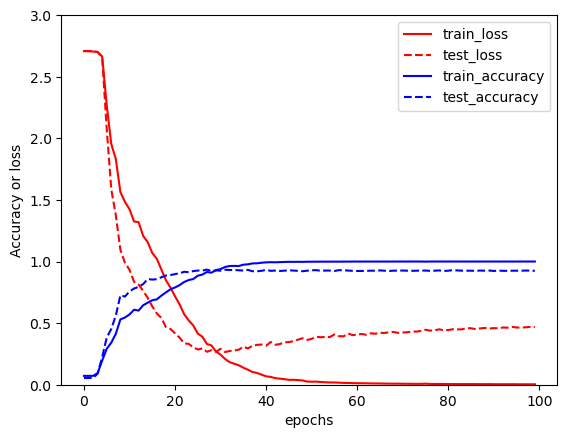

In [163]:
# lossとaccuracyのグラフ化
df_log = pd.DataFrame({"train_loss":train_loss,
             "test_loss":test_loss,
             "train_accuracy":train_acc,
             "test_accuracy":test_acc})

df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
plt.ylim([0,3])
plt.ylabel("Accuracy or loss")
plt.xlabel("epochs")
plt.show()

In [ ]:
# # lossのグラフ化
# df_log = pd.DataFrame({"train_loss":train_loss,
#              "test_loss":test_loss,
#              "train_accuracy":train_acc,
#              "test_accuracy":test_acc})
# df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
# plt.ylabel("loss or accuracy")
# plt.xlabel("epochs")
# plt.show()

## 学習済みモデルの出力

In [162]:
with open("katakana_model.pickle", "wb") as f:
    pickle.dump(tnet, f)

- Google Colab. を使用している人は `katakana_model.pickle` のダウンロードを忘れないようにしよう
  - 「識別精度算出ウェブサイト」への投稿に必要な情報であるため
  - ファイルダウンロードの参考：https://blog.kikagaku.co.jp/google-colab-file#_Google_Colab